##**Mild 2: Model and Training Configuration Optimization based on baseline 2 model**

###**Extension Overview**
This extension focuses on optimizing Baseline 2 (Sequence-to-Sequence model with attention) through model configurations changes and training configuration optimizations.

###**Model Configuration Changes:**

####1. Hidden Size Enhancement:
Increased the hidden state dimension from 256 to 512, providing greater model capacity to capture complex relationships between ingredients and cooking steps.

####2. Enhanced Dropout Implementation:

a. Applied dropout (p=0.2) to both encoder and decoder embedding layers

b. Added dropout before the output layer to enhance regularization


###**Training Configuration Optimizations:**

####1. Sequence Length Control:
Reduced MAX_LENGTH from 100 to 80 tokens to minimize repetition and incoherent content generation, resulting in more concise and meaningful recipes.

####2. Teacher Forcing Rate Adjustment:
Increased the teacher forcing ratio from 0.5 to 0.75 to stabilize training and provide more consistent guidance.


####3. Learning Rate Refinement:
Reduced learning rate from 0.001 to 0.005 to help the model find a more accurate optimal solution.

###**Results and Analysis**
These optimizations resulted in significant performance improvements over Baseline 2:

1. BLEU-4 Score: Improved from 0.0174 to 0.0309 (+77.6%), far exceeding the 10% improvement requirement
2. METEOR Score: Improved from 0.1141 to 0.1606 (+40.8%)
3. BERTScore (F1): Improved from 0.7591 to 0.8041 (+5.9%)

The training process exhibited stable convergence, with the best development loss achieved at epoch 9. Qualitative analysis shows notably improved coherence and specificity in generated recipes, particularly for complex recipes with structured preparation steps.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
file_path = "/content/drive/MyDrive/ColabNotebooks/Cooking_Dataset"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# --- 1. IMPORTS ORGANIZATION ---
import os
import json
import re
import time
import math
import random
from io import open
import unicodedata
import string
from collections import Counter

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from wordcloud import WordCloud

!pip install nltk bert-score
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from bert_score import score as bert_score

import logging
import transformers
logging.getLogger("transformers.modeling_utils").setLevel(logging.ERROR)

In [ ]:
# --- 2. CONSOLIDATED HYPERPARAMETERS ---
# Special tokens
SOS_token = 0
EOS_token = 1
UNK_token = 2
PAD_token = 3

# Model hyperparameters
MAX_LENGTH = 80 # Reduced from 100 to 80 to reduce nonsense and increase BLEU
HIDDEN_SIZE = 512 #Increased from 256 to 512 provides greater expressiveness
DROPOUT_P = 0.2 # Increased from 0.1 to 0.3 to provide stronger regularization for the larger model
BATCH_SIZE = 16
LEARNING_RATE = 0.0005 #Reduced from 0.001 to 0.0005 to compatible with the higher dropout ratea ndhelp the model find a more accurate optimal solution
TEACHER_FORCING_RATIO = 0.75 #Increased from 0.5 to 0.75 to help the model learn faster and more stably
NUM_EPOCHS = 30
PRINT_EVERY = 625
PLOT_EVERY = 625
PATIENCE = 5

# Training data limitation
MAX_TRAIN_SAMPLES = 10000  # Only use first 10000 samples from training set

# Development mode flag
USE_SMALL_TEST = False  # Use a small test set during development

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- 3. NLTK SETUP ---
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

Using device: cuda


True

In [ ]:
# --- 4. LANGUAGE CLASS FOR VOCABULARY ---
class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {"SOS": 0, "EOS": 1, "UNK": 2, "PAD": 3}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS", 2: "UNK", 3: "PAD"}
        self.n_words = 4  # Count SOS, EOS, UNK and PAD

    def addSentence(self, sentence):
        # Add all words in a sentence to the vocabulary
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        # Add a single word to the vocabulary
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

# --- 5. TEXT PREPROCESSING FUNCTIONS ---
def unicodeToAscii(s):
    # Convert Unicode string to ASCII
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

def normalizeString(s):
    # Lowercase, trim, and remove non-letter characters
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z0-9.!?]+", r" ", s)
    return s

def loadData(file_path, file_name, preprocess=True):
    # Load and preprocess data from CSV file
    print(f"Loading data from {file_path}/{file_name}")
    data = pd.read_csv(f"{file_path}/{file_name}")

    # Print the original data (before preprocessing) - only first 3 rows
    print(f"\nOriginal data from {file_name} (first 3 rows):")

    # Display original data with more columns - using pandas options to expand display
    pd.set_option('display.max_columns', None)  # Show all columns
    pd.set_option('display.width', 150)  # Wider display
    pd.set_option('display.max_colwidth', 100)  # Show more content in each cell

    print(data.head(3))

    # Convert ingredients from string representation to actual list
    data['Ingredients'] = data['Ingredients'].apply(eval)

    # Join ingredients into a single string
    data['Ingredients_text'] = data['Ingredients'].apply(lambda x: ' '.join(x))

    if preprocess:
        # Only normalize if preprocess is True
        data['Ingredients_norm'] = data['Ingredients_text'].apply(normalizeString)
        data['Recipe_norm'] = data['Recipe'].apply(normalizeString)

        # Print the preprocessed data - only first 3 rows
        print(f"\nPreprocessed data from {file_name} (first 3 rows):")
        print(data[['Ingredients_norm', 'Recipe_norm']].head(3))

    # Reset pandas display options to default
    pd.reset_option('display.max_columns')
    pd.reset_option('display.width')
    pd.reset_option('display.max_colwidth')

    return data

  # Load and preprocess data
train_data = loadData(file_path, "train.csv", preprocess=True)
dev_data = loadData(file_path, "dev.csv", preprocess=True)
test_data = loadData(file_path, "test.csv", preprocess=False)

# Create vocabularies
input_lang = Lang("ingredients")
output_lang = Lang("recipes")

# Limit training data to the first 10000 samples
train_data_limited = train_data.iloc[:MAX_TRAIN_SAMPLES].copy()
print(f"\nUsing the first {len(train_data_limited)} samples from the training set")
print(f"This is {len(train_data_limited)/len(train_data)*100:.1f}% of the complete training set")

# Add words from limited training data to vocabularies
print("Creating vocabularies from limited training data...")
for i, row in train_data_limited.iterrows():
    input_lang.addSentence(row['Ingredients_norm'])
    output_lang.addSentence(row['Recipe_norm'])

Loading data from /content/drive/MyDrive/ColabNotebooks/Cooking_Dataset/train.csv

Original data from train.csv (first 3 rows):
                  Title                                                                                          Ingredients  \
0   No-Bake Nut Cookies  ["1 c. firmly packed brown sugar", "1/2 c. evaporated milk", "1/2 tsp. vanilla", "1/2 c. broken ...   
1           Creamy Corn  ["2 (16 oz.) pkg. frozen corn", "1 (8 oz.) pkg. cream cheese, cubed", "1/3 c. butter, cubed", "1...   
2  Reeses Cups(Candy)    ["1 c. peanut butter", "3/4 c. graham cracker crumbs", "1 c. melted butter", "1 lb. (3 1/2 c.) p...   

                                                                                                Recipe  
0  ["In a heavy 2-quart saucepan, mix brown sugar, nuts, evaporated milk and butter or margarine.",...  
1  ["In a slow cooker, combine all ingredients. Cover and cook on low for 4 hours or until heated t...  
2  ["Combine first four ingredients and pres

In [ ]:
# --- 6. DATA STATISTICS (AFTER PREPROCESSING) ---
# Same as the Baseline 1

In [ ]:
# --- 7. TENSOR CREATION FUNCTIONS ---
def indexesFromSentence(lang, sentence):
    # Convert a sentence to a list of indices
    return [lang.word2index.get(word, UNK_token) for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence, max_length=MAX_LENGTH):
    # Convert a sentence to a tensor with padding
    indexes = indexesFromSentence(lang, sentence)
    # Truncate if too long
    if len(indexes) > max_length - 1:  # -1 to account for EOS token
        indexes = indexes[:max_length-1]
    indexes.append(EOS_token)
    # Pad if too short
    padding = [PAD_token] * (max_length - len(indexes))
    indexes.extend(padding)
    return torch.tensor(indexes, dtype=torch.long, device=device)

# Prepare training pairs from limited data
train_pairs_limited = [(row['Ingredients_norm'], row['Recipe_norm']) for _, row in train_data_limited.iterrows()]
dev_pairs = [(row['Ingredients_norm'], row['Recipe_norm']) for _, row in dev_data.iterrows()]

# Display a few examples of normalized pairs
print("\nExample of normalized training pairs (first 3):")
for i in range(min(3, len(train_pairs_limited))):
    print(f"Ingredients: {train_pairs_limited[i][0][:80]}...")
    print(f"Recipe: {train_pairs_limited[i][1][:80]}...")
    print()


Example of normalized training pairs (first 3):
Ingredients: 1 c . firmly packed brown sugar 1 2 c . evaporated milk 1 2 tsp . vanilla 1 2 c ...
Recipe:  in a heavy 2 quart saucepan mix brown sugar nuts evaporated milk and butter or ...

Ingredients: 2 16 oz . pkg . frozen corn 1 8 oz . pkg . cream cheese cubed 1 3 c . butter cub...
Recipe:  in a slow cooker combine all ingredients . cover and cook on low for 4 hours or...

Ingredients: 1 c . peanut butter 3 4 c . graham cracker crumbs 1 c . melted butter 1 lb . 3 1...
Recipe:  combine first four ingredients and press in 13 x 9 inch ungreased pan . melt ch...



In [ ]:
# --- 8. DATASET CLASS ---
class RecipeDataset(Dataset):
    def __init__(self, pairs, input_lang, output_lang, max_length=MAX_LENGTH):
        self.pairs = pairs
        self.input_lang = input_lang
        self.output_lang = output_lang
        self.max_length = max_length

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        pair = self.pairs[idx]
        input_tensor = tensorFromSentence(self.input_lang, pair[0], self.max_length)
        target_tensor = tensorFromSentence(self.output_lang, pair[1], self.max_length)
        return input_tensor, target_tensor

# Create datasets and dataloaders
train_dataset = RecipeDataset(train_pairs_limited, input_lang, output_lang)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

dev_dataset = RecipeDataset(dev_pairs, input_lang, output_lang)
dev_dataloader = DataLoader(dev_dataset, batch_size=BATCH_SIZE)

In [ ]:
# --- 9. ENCODER MODEL ---
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=DROPOUT_P):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.dropout = nn.Dropout(dropout_p)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)

    def forward(self, input, hidden):
        # Forward pass through the encoder
        batch_size = input.size(0)

        # Embedding: [batch_size, seq_len] -> [batch_size, seq_len, hidden_size]
        embedded = self.embedding(input)
        embedded = self.dropout(embedded)  # New: Add dropout to encoder embedding layer

        # Initialize hidden if None
        if hidden is None:
            hidden = self.initHidden(batch_size)

        # GRU forward pass
        output, hidden = self.gru(embedded, hidden)
        return output, hidden

    def initHidden(self, batch_size):
        # Initialize hidden state with zeros
        return torch.zeros(1, batch_size, self.hidden_size, device=device)

# --- 10. DECODER MODEL ---
# --- Attention Mechanism ---
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.hidden_size = hidden_size
        self.attn = nn.Linear(hidden_size * 2, hidden_size)
        self.v = nn.Linear(hidden_size, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        # hidden: [1, batch_size, hidden_size]
        # encoder_outputs: [batch_size, seq_len, hidden_size]

        batch_size = encoder_outputs.size(0)
        seq_len = encoder_outputs.size(1)

        # Reshape hidden to prepare for concatenation
        # [1, batch_size, hidden_size] -> [batch_size, 1, hidden_size]
        hidden = hidden.transpose(0, 1)

        # Repeat hidden state across sequence length
        # [batch_size, 1, hidden_size] -> [batch_size, seq_len, hidden_size]
        hidden = hidden.repeat(1, seq_len, 1)

        # Concatenate hidden state with each encoder output
        # [batch_size, seq_len, hidden_size * 2]
        concat = torch.cat((hidden, encoder_outputs), dim=2)

        # Calculate energy
        # [batch_size, seq_len, hidden_size]
        energy = torch.tanh(self.attn(concat))

        # Calculate attention weights
        # [batch_size, seq_len, 1] -> [batch_size, seq_len]
        attention = self.v(energy).squeeze(2)

        # Apply softmax to get attention weights summing to 1
        # [batch_size, seq_len]
        return F.softmax(attention, dim=1)

class AttentionDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=DROPOUT_P):
        super(AttentionDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = Attention(hidden_size)
        self.gru = nn.GRU(hidden_size * 2, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(self.dropout_p)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=2)

    def forward(self, input, hidden, encoder_outputs):
        # input: [batch_size] or [batch_size, 1]
        # hidden: [1, batch_size, hidden_size]
        # encoder_outputs: [batch_size, seq_len, hidden_size]

        # Ensure input has batch_first dimension
        if input.dim() == 1:
            input = input.unsqueeze(1)  # [batch_size] -> [batch_size, 1]

        # Embed input
        embedded = self.embedding(input)  # [batch_size, 1, hidden_size]
        embedded = self.dropout(embedded)

        # Calculate attention weights
        attn_weights = self.attention(hidden, encoder_outputs)  # [batch_size, seq_len]

        # Create context vector by applying attention weights to encoder outputs
        # [batch_size, 1, seq_len] x [batch_size, seq_len, hidden_size] = [batch_size, 1, hidden_size]
        context = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs)

        # Combine embedded input and context vector
        rnn_input = torch.cat((embedded, context), dim=2)  # [batch_size, 1, hidden_size*2]

        # GRU forward pass
        output, hidden = self.gru(rnn_input, hidden)  # [batch_size, 1, hidden_size]

        # New: Apply dropout before the output layer for enhanced regularization
        output = self.dropout(output)

        # Apply output layer to transform hidden features to vocabulary scores
        output = self.out(output)  # [batch_size, 1, output_size]

        # Apply log softmax along vocabulary dimension (dim=2)
        output = self.softmax(output)  # [batch_size, 1, output_size] - logits transformed to log probabilities

        return output, hidden, attn_weights

    def initHidden(self, batch_size):
        return torch.zeros(1, batch_size, self.hidden_size, device=device)

# Initialize models
encoder = EncoderRNN(input_lang.n_words, HIDDEN_SIZE, dropout_p=DROPOUT_P).to(device)
attention_decoder = AttentionDecoderRNN(HIDDEN_SIZE, output_lang.n_words, dropout_p=DROPOUT_P).to(device)

# Define optimizer and loss function
encoder_optimizer = optim.Adam(encoder.parameters(), lr=LEARNING_RATE)
decoder_optimizer = optim.Adam(attention_decoder.parameters(), lr=LEARNING_RATE)
criterion = nn.NLLLoss(ignore_index=PAD_token, reduction='sum')

In [ ]:
# --- 11. TRAINING FUNCTION ---
def train_batch_attention(input_batch, target_batch, encoder, decoder,
                         encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    # Train the model on a single batch with attention
    batch_size = input_batch.size(0)

    # Zero the gradients
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    # Initialize loss
    loss = 0

    # Initialize encoder hidden state
    encoder_hidden = encoder.initHidden(batch_size)

    # Process the input batch through the encoder
    encoder_outputs, encoder_hidden = encoder(input_batch, encoder_hidden)

    # First decoder input is the SOS token for each item in the batch
    decoder_input = torch.tensor([SOS_token] * batch_size, device=device)

    # Set decoder hidden state to the encoder's final hidden state
    decoder_hidden = encoder_hidden

    # Determine whether to use teacher forcing
    use_teacher_forcing = True if random.random() < TEACHER_FORCING_RATIO else False

    # Teacher forcing: use the ground-truth target as the next input
    if use_teacher_forcing:
        for di in range(target_batch.size(1)):
            decoder_output, decoder_hidden, _ = decoder(decoder_input, decoder_hidden, encoder_outputs)

            # Calculate loss for the current timestep
            loss += criterion(decoder_output.squeeze(1), target_batch[:, di])

            # Next input is current target
            decoder_input = target_batch[:, di]

    # Without teacher forcing: use decoder's own prediction as the next input
    else:
        for di in range(target_batch.size(1)):
            decoder_output, decoder_hidden, _ = decoder(decoder_input, decoder_hidden, encoder_outputs)

            # Get the most likely word index
            topv, topi = decoder_output.squeeze(1).topk(1)
            decoder_input = topi.squeeze(1).detach()  # Detach from history as input

            # Calculate loss
            loss += criterion(decoder_output.squeeze(1), target_batch[:, di])

            # Stop if all sequences in batch reached EOS
            if (decoder_input == EOS_token).all():
                break

    # Backpropagate
    loss.backward()

    # Clip gradients to prevent exploding gradients
    torch.nn.utils.clip_grad_norm_(encoder.parameters(), 1)
    torch.nn.utils.clip_grad_norm_(decoder.parameters(), 1)

    # Update weights
    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / batch_size

In [ ]:
# --- 12. EVALUATION FUNCTION ---
def evaluate_attention(encoder, decoder, sentence, max_length=MAX_LENGTH):
    # Generate a recipe from ingredients using the trained model with attention
    with torch.no_grad():
        # Normalize the input sentence
        normalized_sentence = normalizeString(sentence)

        # Create a list of indices from the sentence and add EOS
        indexes = [input_lang.word2index.get(word, UNK_token) for word in normalized_sentence.split(' ')]
        if len(indexes) > max_length - 1:
            indexes = indexes[:max_length-1]
        indexes.append(EOS_token)

        # Create input tensor [seq_len]
        input_tensor = torch.tensor(indexes, dtype=torch.long, device=device)

        # Add batch dimension [1, seq_len]
        input_tensor = input_tensor.unsqueeze(0)

        # Initialize encoder hidden state
        encoder_hidden = encoder.initHidden(1)

        # Pass through the encoder
        encoder_outputs, encoder_hidden = encoder(input_tensor, encoder_hidden)

        # Initialize decoder input - single SOS token
        decoder_input = torch.tensor([[SOS_token]], device=device)  # [1, 1]

        decoder_hidden = encoder_hidden

        decoded_words = []

        # Step-by-step decoding
        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)

            # Get the word with highest probability
            topv, topi = decoder_output.topk(1, dim=2)
            topi = topi.squeeze(-1)  # Remove the last dimension

            # Get word index
            word_idx = topi.item() if topi.numel() == 1 else topi[0].item()

            # Handle special tokens
            if word_idx == EOS_token:
                decoded_words.append('<EOS>')
                break
            elif word_idx == PAD_token:
                continue
            else:
                if word_idx < len(output_lang.index2word):
                    word = output_lang.index2word[word_idx]
                    decoded_words.append(word)
                else:
                    unk_word = f"<UNK-{word_idx}>"
                    decoded_words.append(unk_word)

            # Prepare the next input - keep shape [1, 1]
            decoder_input = torch.tensor([[word_idx]], device=device)

        # Combine the result
        result = ' '.join([word for word in decoded_words if word != '<EOS>'])
        return result

# --- 13. DEVELOPMENT EVALUATION FUNCTION ---
def develop_attention(encoder, decoder, dataloader, criterion, max_length=MAX_LENGTH):
    # Evaluate the model on the development set with attention
    encoder.eval()
    decoder.eval()

    total_loss = 0
    with torch.no_grad():
        for i, (input_batch, target_batch) in enumerate(dataloader):
            batch_size = input_batch.size(0)

            # Initialize encoder hidden state
            encoder_hidden = encoder.initHidden(batch_size)

            # Process the input batch through the encoder
            encoder_outputs, encoder_hidden = encoder(input_batch, encoder_hidden)

            # First decoder input is the SOS token for each item in the batch
            decoder_input = torch.tensor([SOS_token] * batch_size, device=device)

            # Set decoder hidden state to the encoder's final hidden state
            decoder_hidden = encoder_hidden

            # Initialize loss
            loss = 0

            # Decode one step at a time
            for di in range(target_batch.size(1)):
                decoder_output, decoder_hidden, _ = decoder(decoder_input, decoder_hidden, encoder_outputs)

                # Calculate loss
                loss += criterion(decoder_output.squeeze(1), target_batch[:, di])

                # Next input is ground truth
                decoder_input = target_batch[:, di]

            total_loss += loss.item() / batch_size

    avg_loss = total_loss / len(dataloader)
    return avg_loss

In [ ]:
# --- 14. TRAINING LOOP ---
def train_epochs_attention(encoder, decoder, train_dataloader, dev_dataloader,
                         encoder_optimizer, decoder_optimizer, criterion,
                         num_epochs, print_every=PRINT_EVERY, plot_every=PLOT_EVERY):
    # Train the model for multiple epochs with attention
    start = time.time()
    train_losses = []
    dev_losses = []
    plot_losses = []
    print_loss_total = 0
    plot_loss_total = 0
    best_dev_loss = float('inf')

    # Early Stopping
    patience = PATIENCE
    no_improve_count = 0

    for epoch in range(num_epochs):
        encoder.train()
        decoder.train()

        epoch_loss = 0
        batch_count = 0

        for i, (input_batch, target_batch) in enumerate(train_dataloader):
            batch_count += 1

            # Train on this batch
            loss = train_batch_attention(input_batch, target_batch, encoder, decoder,
                             encoder_optimizer, decoder_optimizer, criterion)

            # Accumulate loss
            print_loss_total += loss
            plot_loss_total += loss
            epoch_loss += loss

            # Update plot
            if batch_count % plot_every == 0:
                plot_loss_avg = plot_loss_total / plot_every
                plot_losses.append(plot_loss_avg)
                plot_loss_total = 0

        # Calculate average loss for the epoch
        avg_epoch_loss = epoch_loss / len(train_dataloader)
        print(f"Epoch {epoch+1}/{num_epochs} complete | Average Loss: {avg_epoch_loss:.4f}")

        # Develop
        dev_loss = develop_attention(encoder, decoder, dev_dataloader, criterion)
        print(f"Development Loss: {dev_loss:.4f}")

        # Store losses for plotting
        train_losses.append(avg_epoch_loss)
        dev_losses.append(dev_loss)

        # Early Stopping
        if dev_loss < best_dev_loss:
            best_dev_loss = dev_loss
            no_improve_count = 0
            print(f"New best development loss: {dev_loss:.4f}")

            # Save best model
            torch.save({
                'encoder_state_dict': encoder.state_dict(),
                'decoder_state_dict': decoder.state_dict(),
            }, f"{file_path}/Mild2_best_model.pt")
            print("Best model saved.")
        else:
            no_improve_count += 1

        if no_improve_count >= patience:
            print(f"Early stopping after {epoch+1} epochs")
            break

    # Show the loss plot
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses) + 1), train_losses, 'b-', label='Training Loss')
    plt.plot(range(1, len(dev_losses) + 1), dev_losses, 'r-', label='Development Loss')
    plt.title('Training and Development Loss (with Attention)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{file_path}/loss_plot_attention.png")  # Save the plot
    plt.show()

    time_taken = time.time() - start
    print(f"Training completed in {time_taken/60:.2f} minutes")

    return train_losses, dev_losses

In [ ]:
# --- 15. EVALUATION METRICS ---
def calculate_metrics(reference, hypothesis):
    # Calculate BLEU-4, METEOR, and BERTScore metrics
    try:
        # Tokenize for metrics calculation
        ref_tokens = nltk.word_tokenize(reference)
        hyp_tokens = nltk.word_tokenize(hypothesis)

        # BLEU-4 with smoothing
        smoothie = SmoothingFunction().method4
        bleu = sentence_bleu([ref_tokens], hyp_tokens,
                            weights=(0.25, 0.25, 0.25, 0.25),
                            smoothing_function=smoothie)

        # METEOR
        meteor = meteor_score([ref_tokens], hyp_tokens)

        # BERTScore
        P, R, F1 = bert_score([hypothesis], [reference], lang='en', verbose=False)
        bertscore = F1.numpy().item()

        return bleu, meteor, bertscore

    except Exception as e:
        print(f"Error calculating metrics: {e}")
        return 0.0, 0.0, 0.0


Starting training with attention...
Epoch 1/30 complete | Average Loss: 196.5277
Development Loss: 149.5327
New best development loss: 149.5327
Best model saved.
Epoch 2/30 complete | Average Loss: 167.0014
Development Loss: 136.8265
New best development loss: 136.8265
Best model saved.
Epoch 3/30 complete | Average Loss: 155.7526
Development Loss: 131.0856
New best development loss: 131.0856
Best model saved.
Epoch 4/30 complete | Average Loss: 150.8666
Development Loss: 127.4981
New best development loss: 127.4981
Best model saved.
Epoch 5/30 complete | Average Loss: 144.0431
Development Loss: 124.7204
New best development loss: 124.7204
Best model saved.
Epoch 6/30 complete | Average Loss: 142.4443
Development Loss: 123.6903
New best development loss: 123.6903
Best model saved.
Epoch 7/30 complete | Average Loss: 140.7650
Development Loss: 123.1369
New best development loss: 123.1369
Best model saved.
Epoch 8/30 complete | Average Loss: 134.2832
Development Loss: 122.3088
New best 

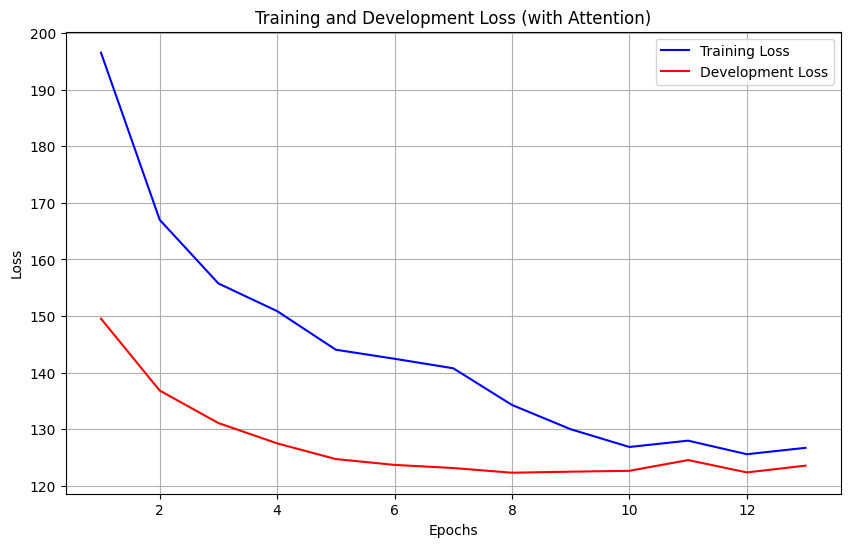

Training completed in 31.66 minutes


([196.52770482177735,
  167.00144846191407,
  155.7525593017578,
  150.8666298828125,
  144.0431495361328,
  142.44425909423828,
  140.76495234375,
  134.28316225585937,
  129.9933296875,
  126.85710541992188,
  127.97695435180664,
  125.57743541259765,
  126.70631646728516],
 [149.53269037401697,
  136.8264869702594,
  131.08564759566022,
  127.49812151148149,
  124.72042208998951,
  123.69028068023732,
  123.13688515430658,
  122.30877623550137,
  122.49497295019044,
  122.64547399264663,
  124.54457017636022,
  122.36246398116027,
  123.5574585138071])

In [ ]:
# --- 16. MAIN EXECUTION BLOCK ---
# Start training
print("\nStarting training with attention...")
train_epochs_attention(
    encoder, attention_decoder, train_dataloader, dev_dataloader,
    encoder_optimizer, decoder_optimizer, criterion,
    NUM_EPOCHS, PRINT_EVERY, PLOT_EVERY
)

In [ ]:
# Save final model
torch.save({
   'encoder_state_dict': encoder.state_dict(),
   'decoder_state_dict': attention_decoder.state_dict(),
}, f"{file_path}/Mild2_final_model.pt")
print("Final model saved.")

Final model saved.


In [ ]:
# Evaluate on test data
print("\nEvaluating attention model on test data...")

# Decide whether to use a subset of test data for evaluation
if USE_SMALL_TEST:
   # Use only the first 10 samples
   test_subset = test_data[:10]
   print(f"Using {len(test_subset)} test samples for evaluation (development mode)")
else:
   # Use all test data
   test_subset = test_data
   print(f"Using all {len(test_data)} test samples for evaluation (production mode)")

# Set models to evaluation mode
encoder.eval()
attention_decoder.eval()

# Initialize lists to store results
test_results = []
bleu_scores = []
meteor_scores = []
bertscore_scores = []

# Process test data
for idx, row in test_subset.iterrows():
    ingredients_text = row['Ingredients_text']
    original_recipe = row['Recipe']

    # Generate recipe
    generated_recipe = evaluate_attention(encoder, attention_decoder, ingredients_text)

    # Normalize original recipe for evaluation
    normalized_recipe = normalizeString(original_recipe)

    # Calculate metrics
    bleu, meteor, bertscore = calculate_metrics(normalized_recipe, generated_recipe)

    # Store results
    test_results.append({
        'ingredients': ingredients_text,
        'original_recipe': original_recipe,
        'generated_recipe': generated_recipe,
        'bleu': bleu,
        'meteor': meteor,
        'bertscore': bertscore
    })

    # Accumulate scores for averaging
    bleu_scores.append(bleu)
    meteor_scores.append(meteor)
    bertscore_scores.append(bertscore)

    # Print progress every 100 samples
    if (idx + 1) % 100 == 0:
        print(f"Processed {idx + 1}/{len(test_subset)} test samples")

# Convert results to DataFrame
results_df = pd.DataFrame(test_results)

# Save results
results_df.to_csv(f"{file_path}/Mild2_results.csv", index=False)
print("Results saved to CSV file.")

# Calculate average metrics
avg_bleu = np.mean(bleu_scores)
avg_meteor = np.mean(meteor_scores)
avg_bertscore = np.mean(bertscore_scores)

print("\nMild 2 (Attention) Evaluation Results:")
print(f"BLEU-4 Score: {avg_bleu:.4f}")
print(f"METEOR Score: {avg_meteor:.4f}")
print(f"BERTScore (F1): {avg_bertscore:.4f}")


Evaluating attention model on test data...
Using all 1081 test samples for evaluation (production mode)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Processed 100/1081 test samples
Processed 200/1081 test samples
Processed 300/1081 test samples
Processed 400/1081 test samples
Processed 500/1081 test samples
Processed 600/1081 test samples
Processed 700/1081 test samples
Processed 800/1081 test samples
Processed 900/1081 test samples


Processed 1000/1081 test samples
Results saved to CSV file.

Mild 2 (Attention) Evaluation Results:
BLEU-4 Score: 0.0309
METEOR Score: 0.1606
BERTScore (F1): 0.8041


In [ ]:
# Qualitative comparison test for presentation
print("\n=== Qualitative Comparison for Presentation (Attention Model) ===")

# Test Sample 1
sample1 = "sugar, lemon juice, water, orange juice, strawberries, icecream"
result1 = evaluate_attention(encoder, attention_decoder, sample1)
words1 = " ".join(result1.split()[:30])
print("\nSample 1:")
print(f"Ingredients: {sample1}")
print(f"First 30 words: {words1}")

# Test Sample 2
sample2 = "8 oz philadelphia cream cheese, 14 oz can sweetened condensed milk, 1 ts vanilla, 1/3 c lemon juice, 48 oz canned cherries, 8 inch graham cracker, pie crusts"
result2 = evaluate_attention(encoder, attention_decoder, sample2)
words2 = " ".join(result2.split()[:30])
print("\nSample 2:")
print(f"Ingredients: {sample2}")
print(f"First 30 words: {words2}")

# Save
with open(f"{file_path}/qualitative_results_Mild2.txt", "w") as f:
    f.write(f"Sample 1 (Mild 2): {words1}\n\n")
    f.write(f"Sample 2 (Mild 2): {words2}\n")

print("\nResults saved to file.")


=== Qualitative Comparison for Presentation (Attention Model) ===

Sample 1:
Ingredients: sugar, lemon juice, water, orange juice, strawberries, icecream
First 30 words: combine sugar lemon juice and water . juice add lemon juice and . . juice . . . . . . . . . . . . . . .

Sample 2:
Ingredients: 8 oz philadelphia cream cheese, 14 oz can sweetened condensed milk, 1 ts vanilla, 1/3 c lemon juice, 48 oz canned cherries, 8 inch graham cracker, pie crusts
First 30 words: soften cream cheese and sweetened condensed milk . add lemon juice and vanilla . mix well . pour into pie crust . chill . . . . . . .

Results saved to file.
